<a href="https://colab.research.google.com/github/rchicangana/AnalisisDatosProyecto/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1  Introduccion

El análisis exploratorio de datos es una etapa fundamental en cualquier proyecto de Inteligencia Artificial y Ciencia de Datos, puesto que permite entender las características y patrones en los datos, así como identificar relaciones entre variables.

A continuación se presenta un estudio basado en datos de consumo de energía eléctrica horaria registrados en Cali, Colombia, junto con las temperaturas correspondientes a cada hora. El objetivo principal es explorar la relación entre estas dos variables y, posteriormente, aplicar diferentes modelos para realizar el pronósticos de corto plazo del demanda de energía.

# 2  Contexto

La demanda de energía eléctrica en una ciudad se ve inlfuenciada por muchos factores, como la temperatura, factores sociales, cronograma de produccion de grandes clientes, entre otros.

En regiones con climas variables, como es el caso de muchas ciudades Colombianas, la demanda es afectada por el uso intensivo de sistemas de refrigeración en épocas calurosas.

Los datos utilizados en este análisis incluyen mediciones horarias del consumo de energía y la temperatura registrada en la misma franja horaria, tipos de dia, mes y año. Lo que permite explorar la correlación entre estas variables.

Adicionalmente, se busca evaluar el desempeño de diferentes modelos como regresiones lineales, redes neuronales y modelos basados en árboles de decisión, para predecir el consumo de energía en un horizonte de corto plazo.

## 2.1  Descripción de los campos

- FECHA: Fecha en formato ISO de la lectura del consumo
- TEMPERATURA: Temperatura en grados Centigrados al momento de la toma del dato
- CONSUMO: Variable objetvio medido en MVA

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import holidays
# import tensorflow as tf
# from tensorflow import keras

df = pd.read_excel('Data/datasetEmcali_Imputacion.xlsx')

print(df.head())
print(df.info())

                FECHA  TEMPERATURA  CONSUMO  DIA DE LA SEMANA  HORA  \
0 2017-12-01 00:00:00         27.9    409.0                 5     0   
1 2017-12-01 01:00:00         29.0    387.0                 5     1   
2 2017-12-01 02:00:00         29.1    378.0                 5     2   
3 2017-12-01 03:00:00         28.2    370.0                 5     3   
4 2017-12-01 04:00:00         26.7    364.0                 5     4   

  TIPO DE DIA  
0   ordinario  
1   ordinario  
2   ordinario  
3   ordinario  
4   ordinario  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29520 entries, 0 to 29519
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             29520 non-null  datetime64[ns]
 1   TEMPERATURA       29520 non-null  float64       
 2   CONSUMO           29520 non-null  float64       
 3   DIA DE LA SEMANA  29520 non-null  int64         
 4   HORA              29520 non-null  int64 

# 3  Análisis exploratorio


## 3.1  Análisis de estructura


Se realiza un analisis de la forma del dataset, se relacionan tipos de datos, estadisticas descriptivas y valores nulos.

Se adicionan columnas, basadas en la fecha, con la hipotesis que esto permitira al modelo entender e interpretar mejor los datos.

In [ ]:
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['CONSUMO'] = pd.to_numeric(df['CONSUMO'], errors='coerce')
df['TEMPERATURA'] = pd.to_numeric(df['TEMPERATURA'], errors='coerce')

df = df.dropna(subset=['FECHA']) # Elimina las filas donde 'FECHA' es NaN
                                 # final del data set, no tienen informacion

def es_festivo_colombia(fecha):
    """Verifica si una fecha es festivo en Colombia."""
    co_holidays = holidays.CO(years=fecha.year)
    return fecha in co_holidays
df['Es_Festivo'] = df['FECHA'].apply(es_festivo_colombia)

# Extract numerical features from 'FECHA'
df['Year'] = df['FECHA'].dt.year
df['Month'] = df['FECHA'].dt.month
df['Day'] = df['FECHA'].dt.day
df['Hour'] = df['FECHA'].dt.hour
df['Dayofweek'] = df['FECHA'].dt.dayofweek
df['Dayofyear'] = df['FECHA'].dt.dayofyear
df['Weekofyear'] = df['FECHA'].dt.isocalendar().week
df['Is_month_end'] = df['FECHA'].dt.is_month_end
df['Is_month_start'] = df['FECHA'].dt.is_month_start
df['Is_quarter_end'] = df['FECHA'].dt.is_quarter_end
df['Is_quarter_start'] = df['FECHA'].dt.is_quarter_start
df['Is_year_end'] = df['FECHA'].dt.is_year_end
df['Is_year_start'] = df['FECHA'].dt.is_year_start

# Crear un diccionario de mapeo
dias_semana = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

# Aplicar el mapeo a la columna 'Dayofweek'
df['Dia_Semana'] = df['Dayofweek'].map(dias_semana)
df = df.drop(['Dayofweek'], axis=1)

print("Forma de lo datos:", df.shape)
print("\nTipo de datos por columnas:\n\n", df.dtypes)
print("\nEstadisticas descriptivas:\n\n", df.describe())
print("\nValores Faltantes:\n\n", df.isnull().sum())
print("\nValores Faltantes(%):\n\n", (df.isnull().sum() / len(df)) * 100)

Forma de lo datos: (29520, 17)

Tipo de datos por columnas:

 FECHA               datetime64[ns]
TEMPERATURA                float64
CONSUMO                    float64
Es_Festivo                    bool
Year                         int32
Month                        int32
Day                          int32
Hour                         int32
Dayofyear                    int32
Weekofyear                  UInt32
Is_month_end                  bool
Is_month_start                bool
Is_quarter_end                bool
Is_quarter_start              bool
Is_year_end                   bool
Is_year_start                 bool
Dia_Semana                  object
dtype: object

Estadisticas descriptivas:

                      FECHA   TEMPERATURA       CONSUMO          Year  \
count                29520  29328.000000  29520.000000  29520.000000   
mean   2019-08-07 23:30:00     24.130615    455.574139   2019.117886   
min    2017-12-01 00:00:00     16.100000    227.000000   2017.000000   
25%    2018

## 3.2  Análisis de variables numericas y continuas


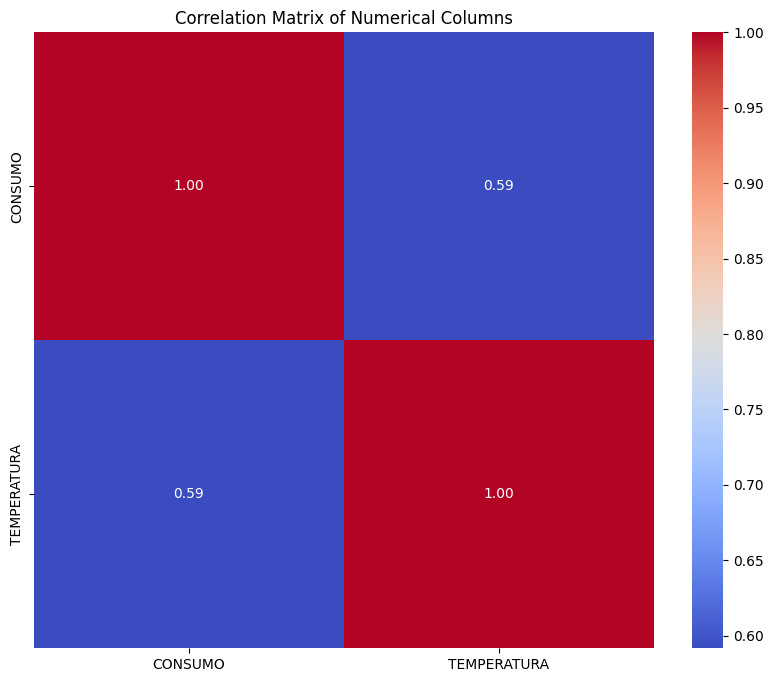

Correlation between TEMPERATURA and CONSUMO: 0.5917020044085186
Correlation between CONSUMO and CONSUMO: 1.0


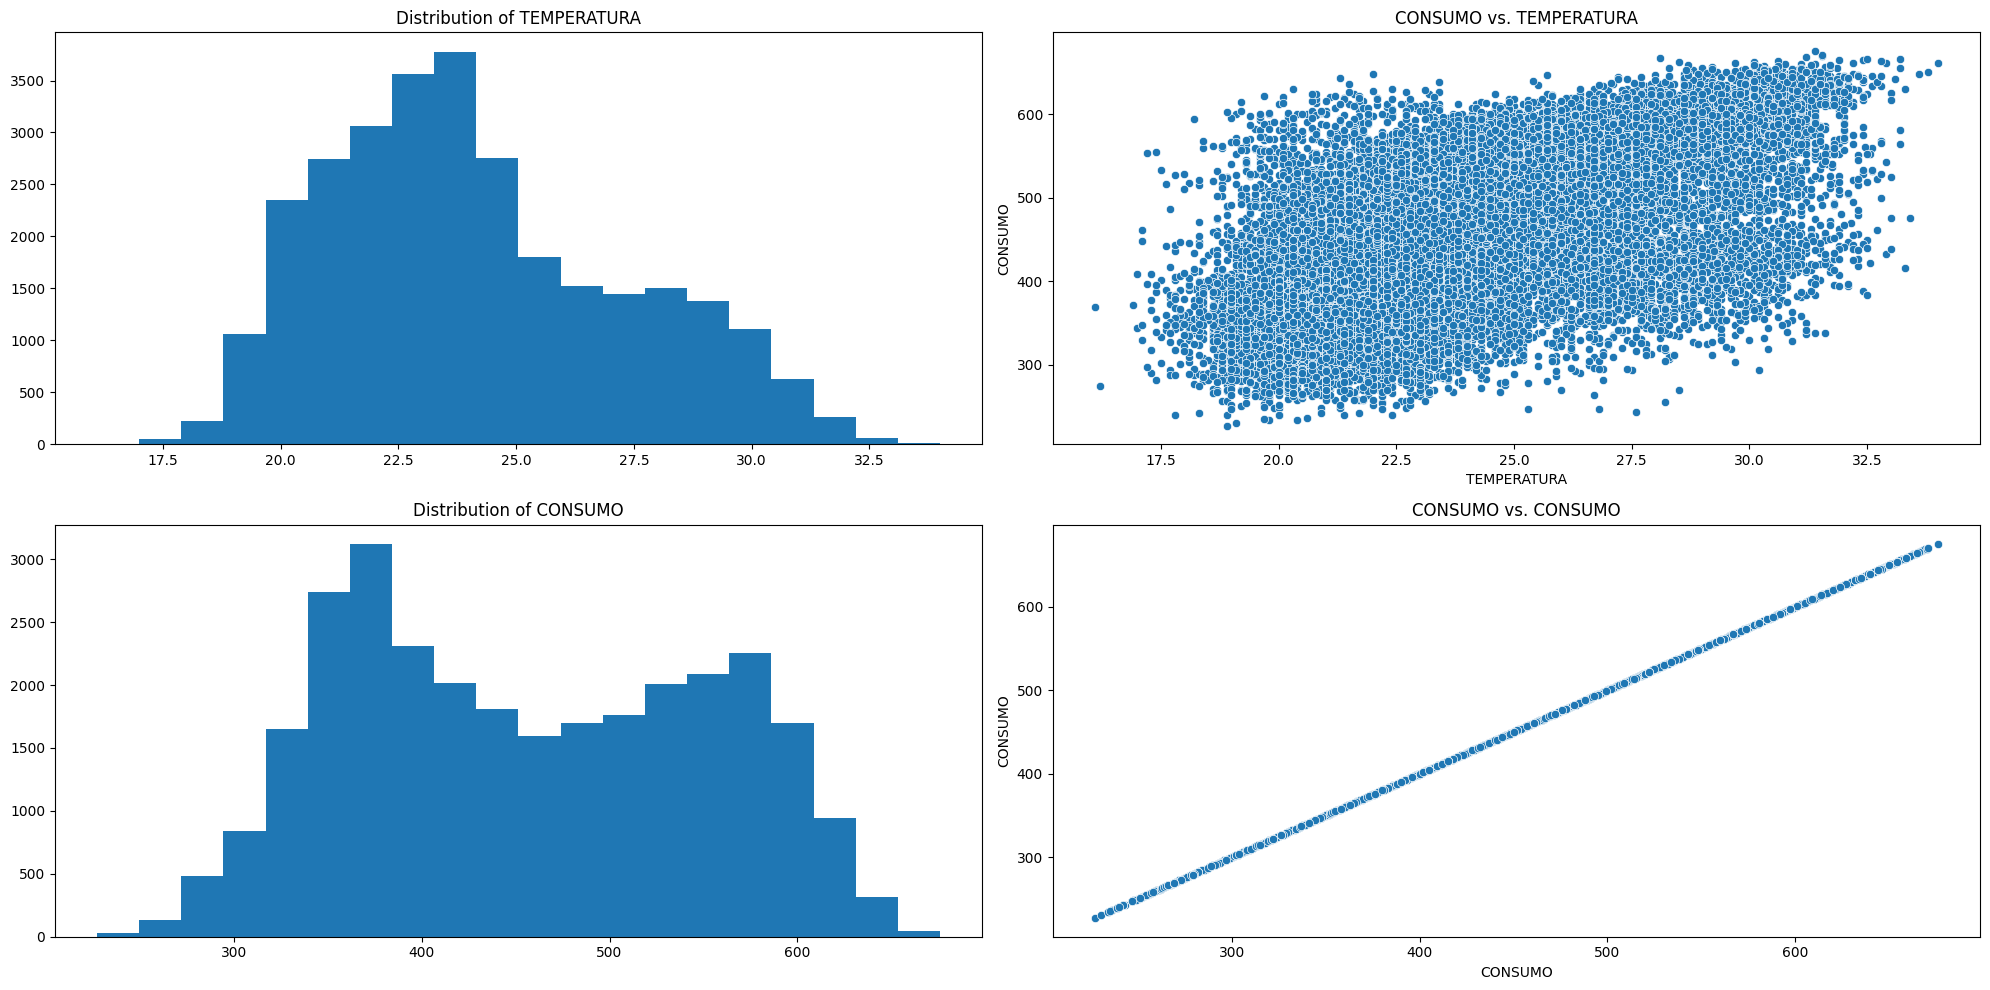

In [145]:
numerical_columns = ['CONSUMO', 'TEMPERATURA']
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

continuous_cols = ['TEMPERATURA', 'CONSUMO']

num_cols = 2  # columns per row
num_rows = (len(continuous_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(continuous_cols):
    # Histogram
    axes[i * 2].hist(df[col], bins=20)
    axes[i * 2].set_title(f'Distribution of {col}')

    # Scatterplot
    sns.scatterplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')

    correlation = df[col].corr(df['CONSUMO'])
    print(f"Correlation between {col} and CONSUMO: {correlation}")

# Remove any unused subplots
for j in range(len(continuous_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 3.3  Análisis de variables Categoricas


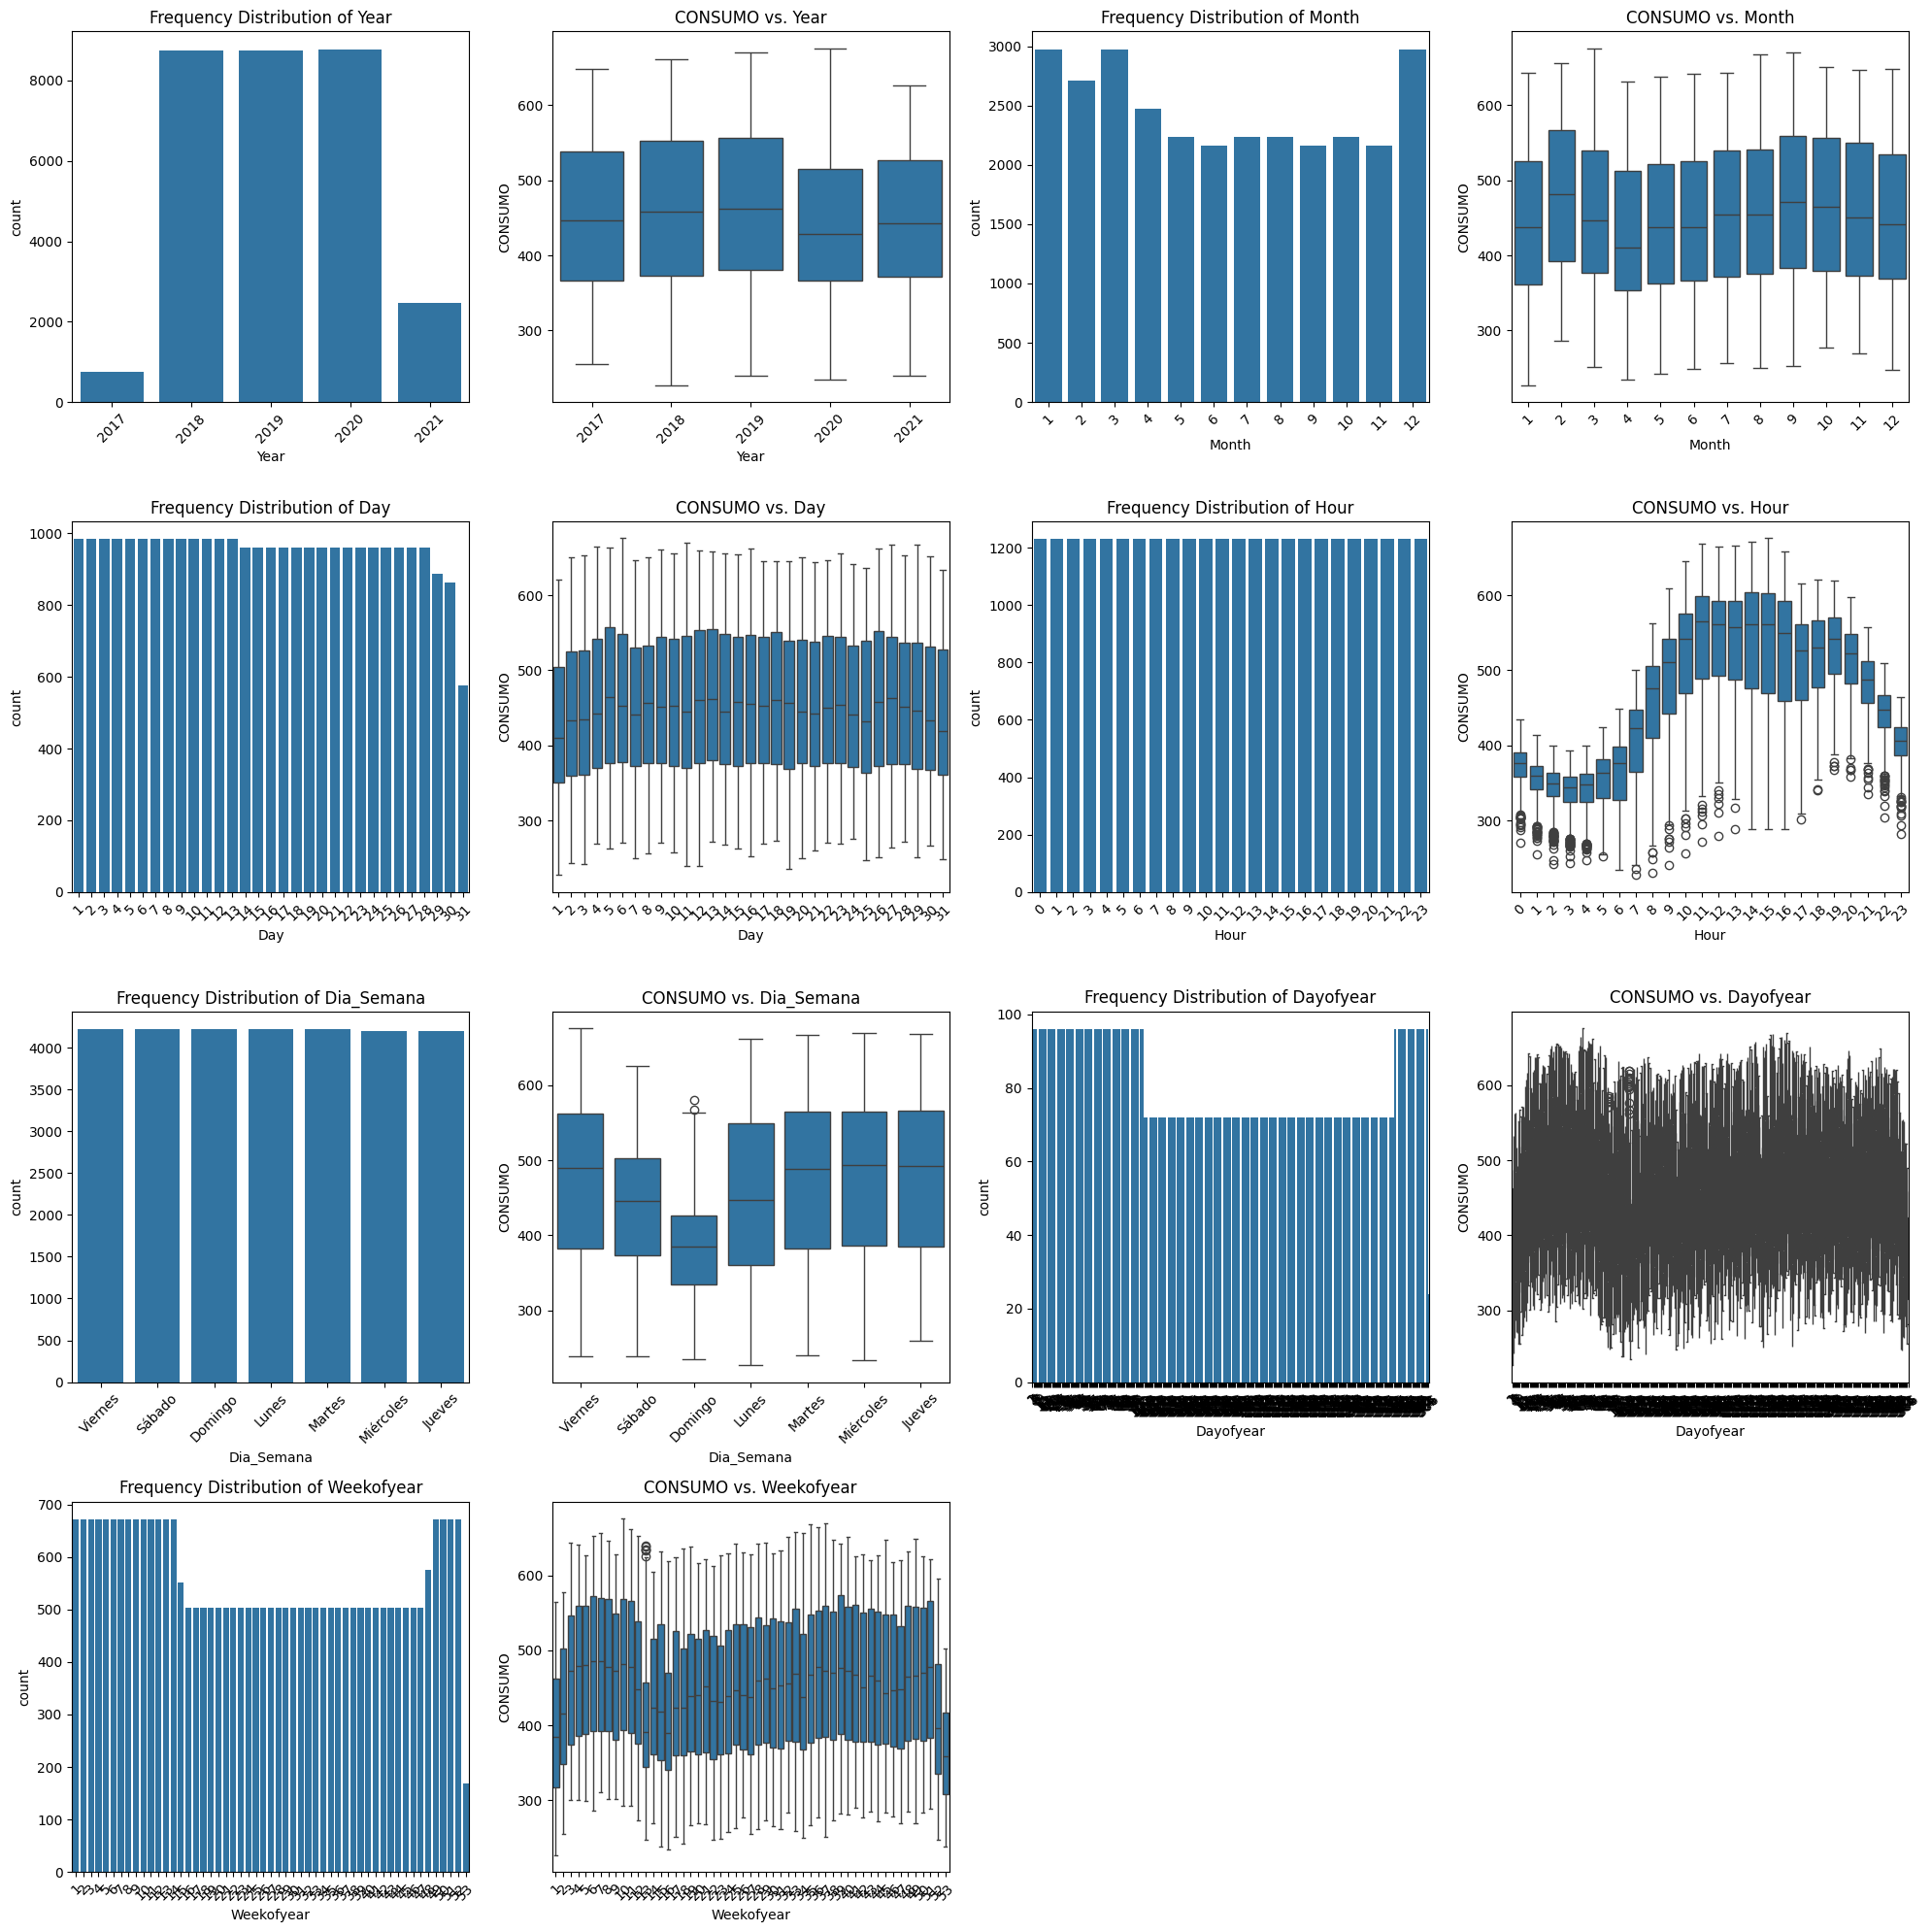

In [146]:
# Assuming 'df' is your DataFrame and 'categorical_cols' is defined
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dia_Semana', 'Dayofyear', 'Weekofyear']

# Determine the number of rows needed for the subplots
num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    # Countplot
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Boxplot
    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

# Remove any unused subplots
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

Los años 2020 y 2021 presentaron un fenomeno social el cual no es posible modelar en este espacio. Las restricciones a la movilidad en la pandemia y el paro nacional, impactaron directamente el consumo de eneriga en la ciudad de Cali.

Se concidera prudente, sacar del estudio estos dos años.

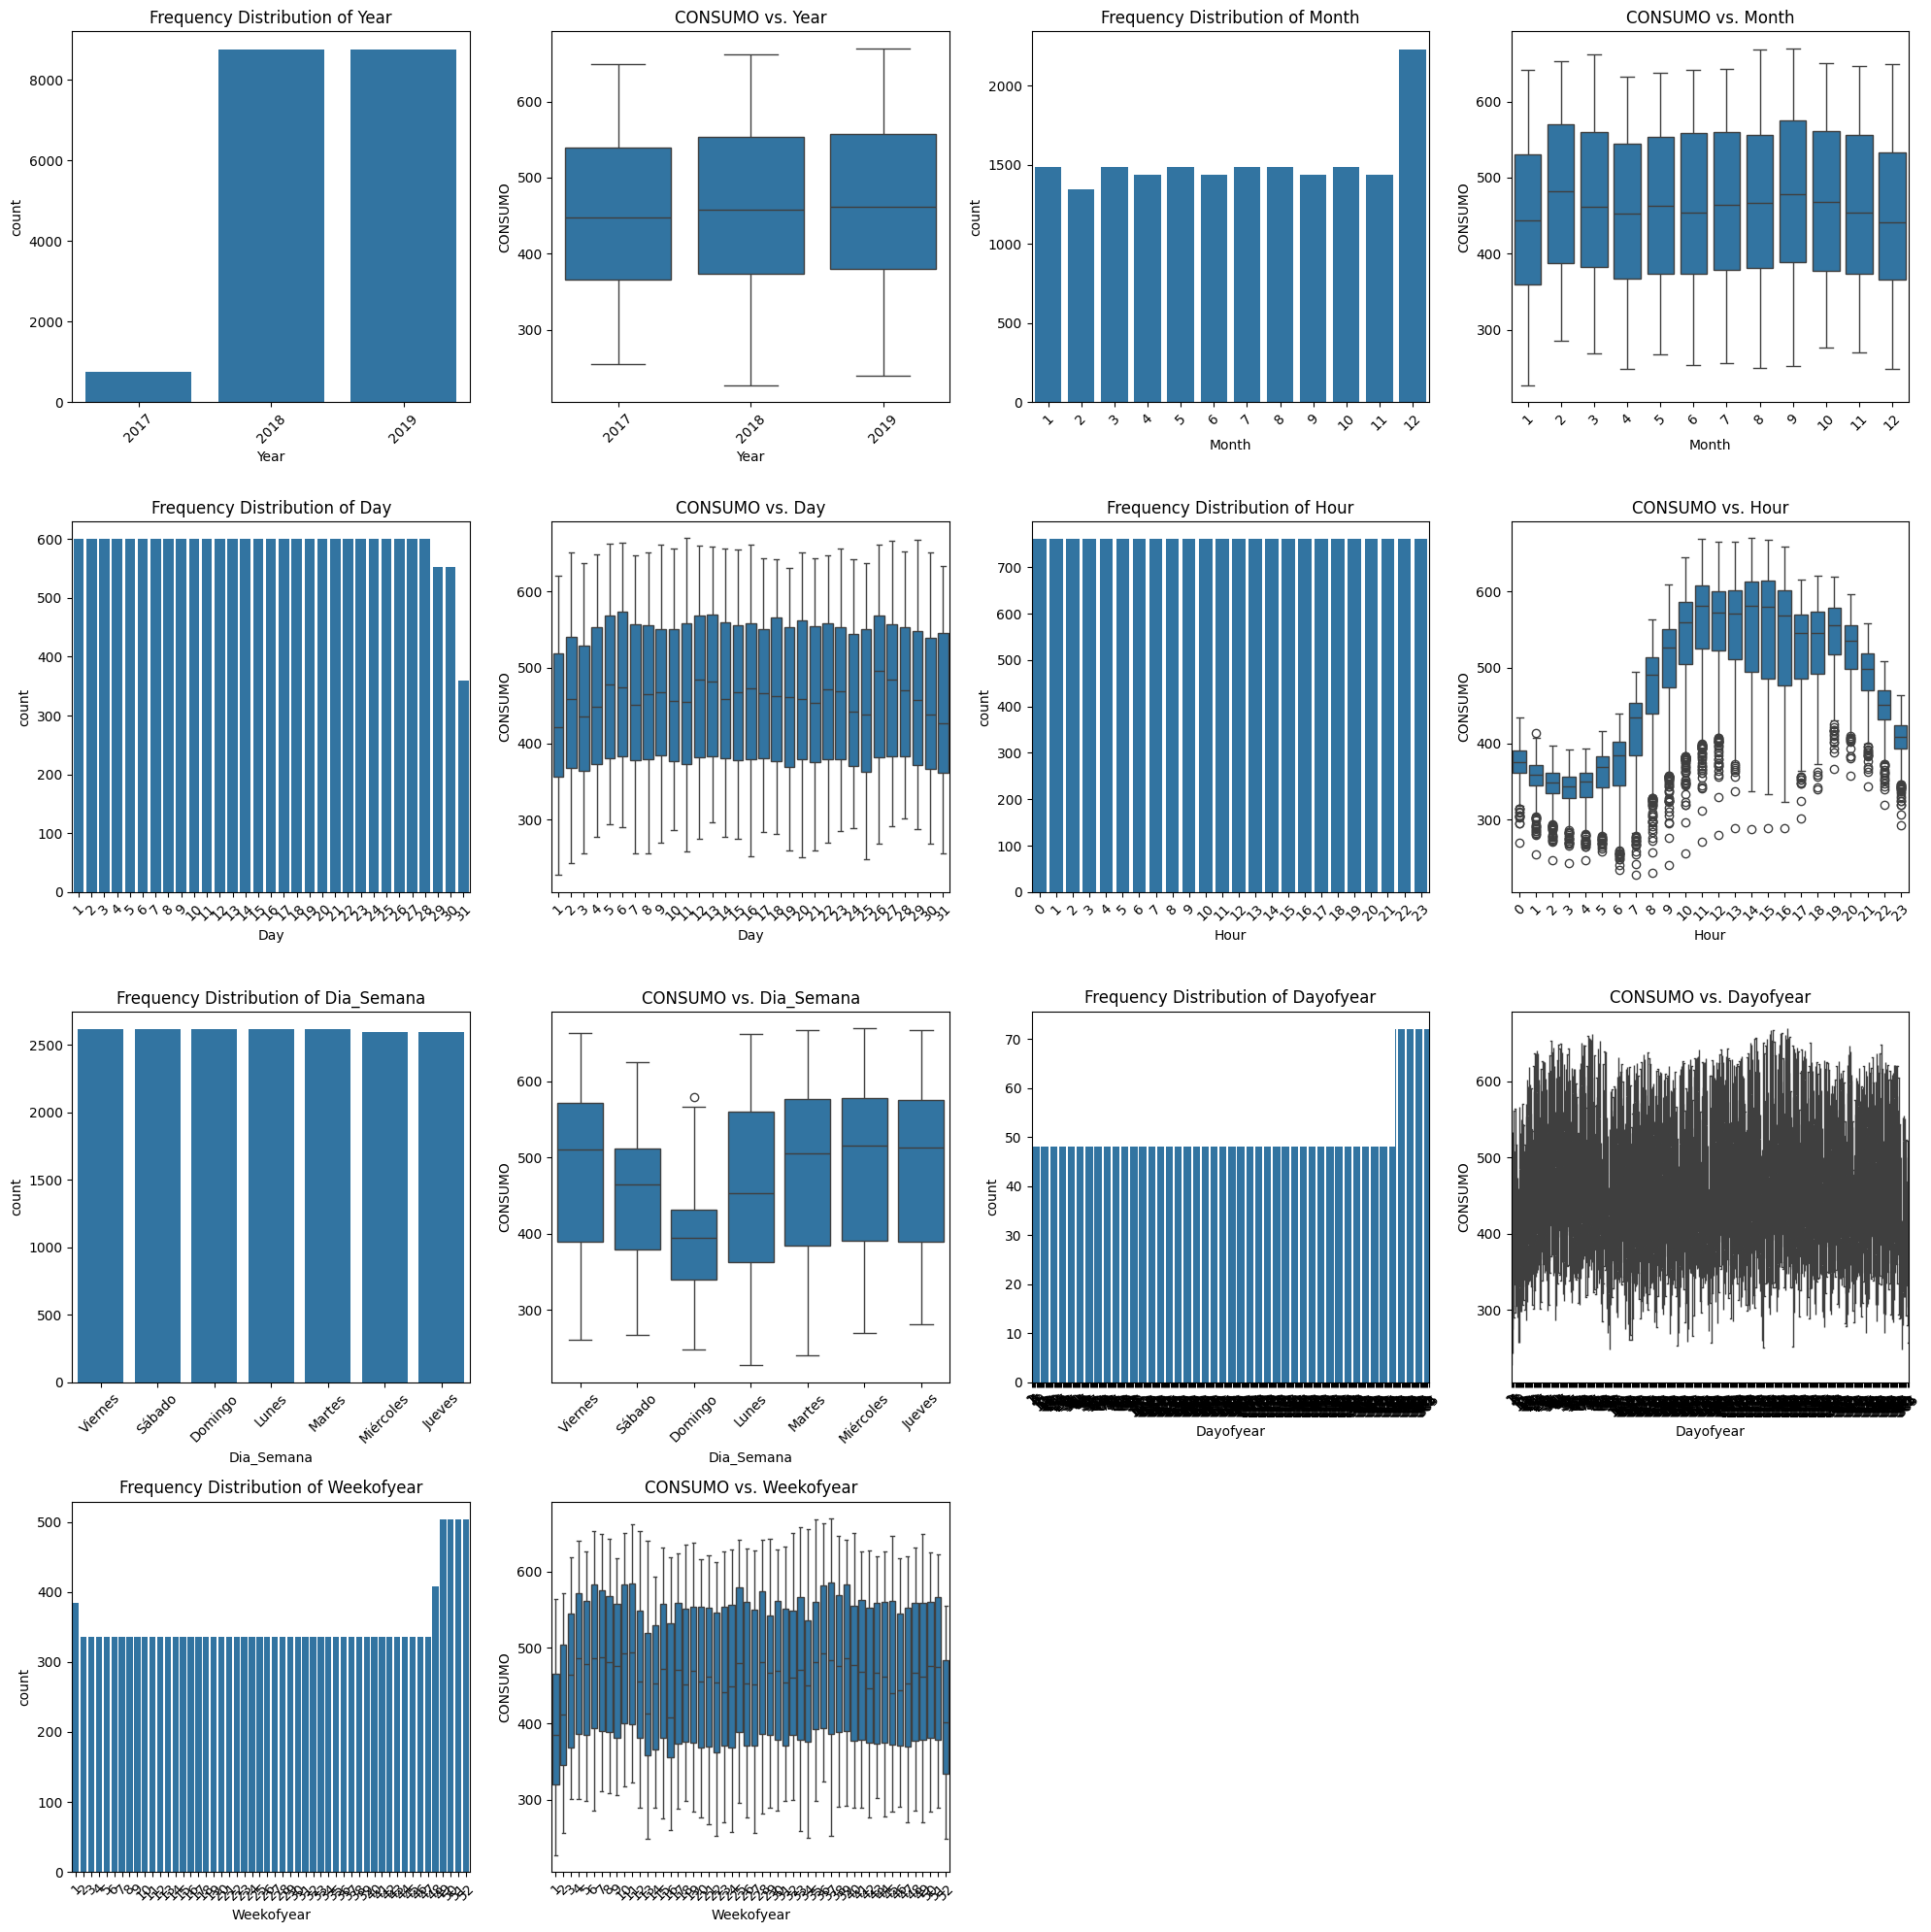

In [147]:
df = df.drop(df[(df['Year'] == 2020) | (df['Year'] == 2021)].index)
df = df.reset_index(drop=True)
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dia_Semana', 'Dayofyear', 'Weekofyear']
num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

### 3.4.1  Analisis de outliers


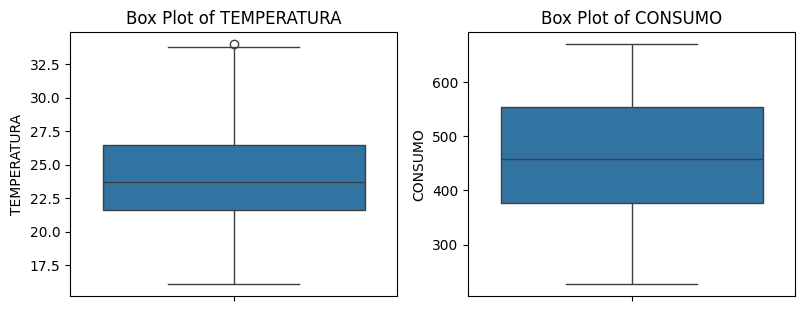


Analysis for numerical variable: TEMPERATURA
count    18264.000000
mean        24.143606
std          3.260349
min         16.100000
25%         21.600000
50%         23.700000
75%         26.500000
max         34.000000
Name: TEMPERATURA, dtype: float64
Number of outliers: 1
Lower bound: 14.250000000000004, Upper bound: 33.849999999999994
Potential causes for outliers in 'TEMPERATURA': Sensor malfunction, extreme weather events
Consequences: Skewed temperature distributions, inaccurate consumption predictions


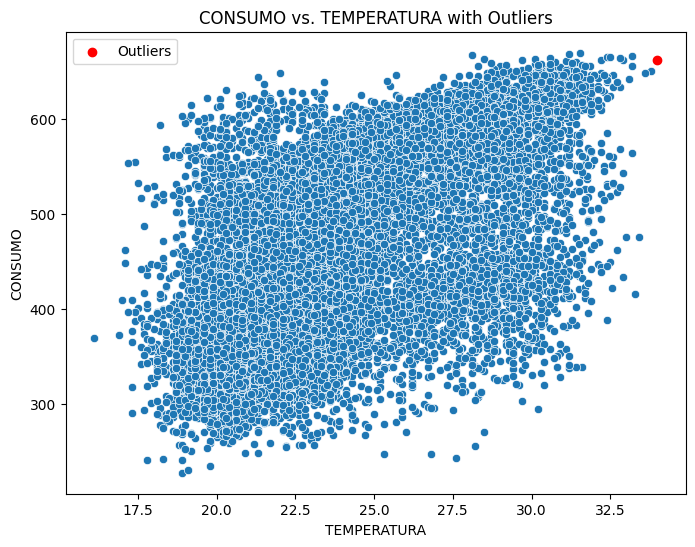


Analysis for numerical variable: CONSUMO
count    18264.000000
mean       464.579172
std         97.515965
min        227.000000
25%        376.000000
50%        459.000000
75%        555.000000
max        670.000000
Name: CONSUMO, dtype: float64
Number of outliers: 0
Lower bound: 107.5, Upper bound: 823.5


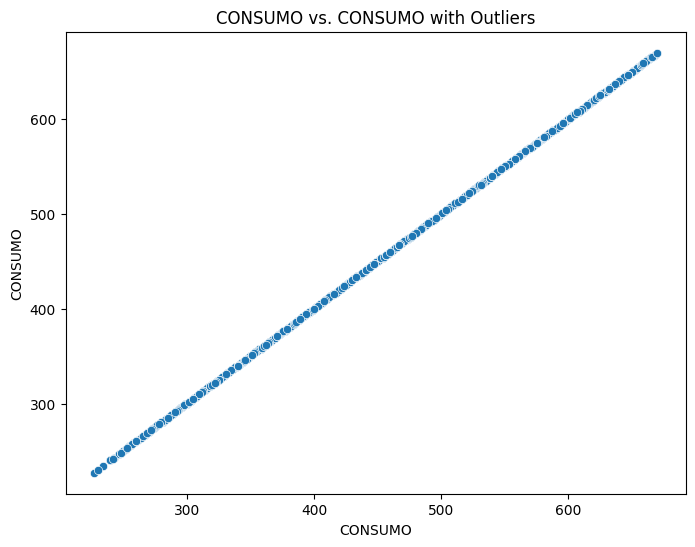

In [148]:
# Columnas numéricas
numerical_cols = ['TEMPERATURA', 'CONSUMO']
# Box plots to visualize outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Descriptive statistics and IQR outlier detection
for col in numerical_cols:
    print(f"\nAnalysis for numerical variable: {col}")
    print(df[col].describe())

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers: {len(outliers)}")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    # Document findings on potential causes and consequences of outliers (example)
    if col == 'TEMPERATURA':
        print("Potential causes for outliers in 'TEMPERATURA': Sensor malfunction, extreme weather events")
        print("Consequences: Skewed temperature distributions, inaccurate consumption predictions")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='CONSUMO', data=df)
    plt.title(f'CONSUMO vs. {col} with Outliers')

    # Highlight outliers on the scatter plot
    if not outliers.empty:
        plt.scatter(outliers[col], outliers['CONSUMO'], color='red', label='Outliers')
        plt.legend()

    plt.show()

### 3.4.2  Conclusiones Outliers


In [150]:
df.isnull().sum()

,0
FECHA,0
TEMPERATURA,0
CONSUMO,0
Es_Festivo,0
Year,0
Month,0
Day,0
Hour,0
Dayofyear,0
Weekofyear,0


# 4  Limpieza de datos


## 4.2  Imputación


In [151]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df_cleaned = df.copy()

# Crea series desplazadas para el valor anterior y siguiente
temperatura_anterior = df_cleaned['TEMPERATURA'].shift(1)
temperatura_siguiente = df_cleaned['TEMPERATURA'].shift(-1)

# Calcula el promedio del valor anterior y siguiente
promedio_anterior_siguiente = (temperatura_anterior + temperatura_siguiente) / 2

# Imputa los valores faltantes con el promedio
df_cleaned['TEMPERATURA'] = df_cleaned['TEMPERATURA'].fillna(promedio_anterior_siguiente)

# Manejar los valores NaN restantes al inicio o al final del DataFrame
df_cleaned['TEMPERATURA'] = df_cleaned['TEMPERATURA'].fillna(df_cleaned['TEMPERATURA'].median()) # Corregido

# Reassign the cleaned DataFrame to df
df = df_cleaned

print(df.head())
print(df.info())
print(df.isnull().sum())

                FECHA  TEMPERATURA  CONSUMO  Es_Festivo  Year  Month  Day  \
0 2017-12-01 00:00:00         27.9    409.0       False  2017     12    1   
1 2017-12-01 01:00:00         29.0    387.0       False  2017     12    1   
2 2017-12-01 02:00:00         29.1    378.0       False  2017     12    1   
3 2017-12-01 03:00:00         28.2    370.0       False  2017     12    1   
4 2017-12-01 04:00:00         26.7    364.0       False  2017     12    1   

   Hour  Dayofyear  Weekofyear  Is_month_end  Is_month_start  Is_quarter_end  \
0     0        335          48         False            True           False   
1     1        335          48         False            True           False   
2     2        335          48         False            True           False   
3     3        335          48         False            True           False   
4     4        335          48         False            True           False   

   Is_quarter_start  Is_year_end  Is_year_start Dia_Sema

## 4.1  Division de datasets


In [152]:
X = df.drop(['CONSUMO'], axis=1)
y = df['CONSUMO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4.2  Estandarización y Escalamiento


Teniendo en cuenta que solo la variable temperatura es numerica y continua no se requiere Escalar o normalizar.

In [112]:
#scaler = MinMaxScaler()
#X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
#X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


# 5  Feature Engineering


## 5.1  Dummificar variables


In [153]:
# Use pd.get_dummies with the 'columns' parameter to specify which columns to dummify
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Check if the number of columns in X_train and X_test are equal
print(f"Number of columns in X_train: {X_train.shape[1]}")
print(f"Number of columns in X_test: {X_test.shape[1]}")

Number of columns in X_train: 503
Number of columns in X_test: 503


## 5.2  PCA


In [154]:
# Split data into training and testing/validation sets
X_train_final, X_test_val, y_train_final, y_test_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

# Split testing/validation set into testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42
)

print(f"X_train_final shape: {X_train_final.shape}, y_train_final shape: {y_train_final.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train_final shape: (10227, 503), y_train_final shape: (10227,)
X_test shape: (2192, 503), y_test shape: (2192,)
X_val shape: (2192, 503), y_val shape: (2192,)


In [155]:
# Initialize PCA with 95% variance retained
pca = PCA(n_components=0.95)

# Fit PCA on the training data
pca.fit(X_train_final)

# Transform the training, testing, and validation data
X_train_pca = pca.transform(X_train_final)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

# Print the explained variance ratio
print(pca.explained_variance_ratio_)

# Replace original data with PCA-transformed data
X_train_final = X_train_pca
X_test = X_test_pca
X_val = X_val_pca

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>)

## 5.3  LDA


## 5.4  Clustering


# 6 Data Pipeline


# 7  Modelamiento

RegresionLineal

In [116]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train_final, y_train_final)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Calculate MAE and MedAE
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 2181.8173117322226
R-squared (R2): 0.7694465957578727
Mean Absolute Error (MAE): 36.17087553129071
Median Absolute Error (MedAE): 29.72401555142872
Root Mean Squared Error (RMSE): 46.709927335976694


Randomforest

In [118]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train_final, y_train_final)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - R-squared (R2): {r2_rf}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)

# Calculate the Median Absolute Error (MedAE)
medae = median_absolute_error(y_test, y_pred_rf)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print the calculated MAE, MedAE, and RMSE values.
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Random Forest - Mean Squared Error (MSE): 960.0326807719883
Random Forest - R-squared (R2): 0.898553008290163
Mean Absolute Error (MAE): 21.503004178887164
Median Absolute Error (MedAE): 15.393841494338801
Root Mean Squared Error (RMSE): 30.984394148861266


Hiperparametros

In [ ]:
# Define la cuadrícula de hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
}

# Crea un objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajusta el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train_final, y_train_final)

# Obtén el mejor modelo
best_model = grid_search.best_estimator_

# Evalúa el mejor modelo en los datos de prueba
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Imprime las métricas de evaluación
print(f"Mejor modelo - Error cuadrático medio (MSE): {mse_best}")
print(f"Mejor modelo - R-cuadrado (R2): {r2_best}")

Red neuronal

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 195305.0469 - val_loss: 30007.4609
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 23196.4238 - val_loss: 6087.0103
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7698.7598 - val_loss: 3041.5684
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5263.8345 - val_loss: 2209.1558
Epoch 5/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4566.9990 - val_loss: 1868.7217
Epoch 6/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4238.1665 - val_loss: 1793.8593
Epoch 7/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4261.1240 - val_loss: 1659.6605
Epoch 8/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4028.3438 - val_loss: 1621.4633
Epoch 9/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4008.0024 - val_loss: 1672.3353
Epoch 10/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3912.2148 - val_loss: 1551.0820
Epoch 11/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3806.9888 - val

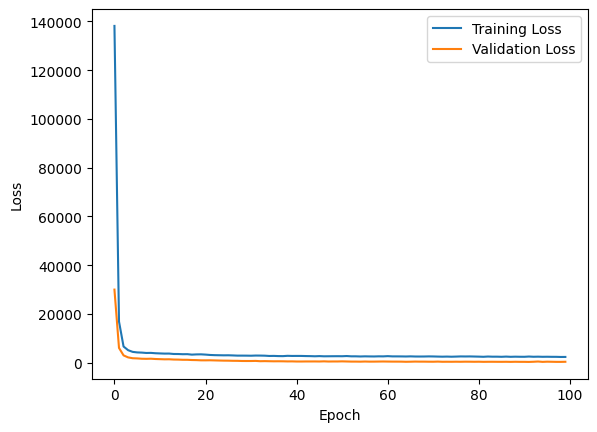

In [119]:
# 1. Definir el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Capa de salida para regresión
])

# 2. Compilar el modelo
model.compile(optimizer='adam', loss='mse')  # Usamos 'mse' (error cuadrático medio) para regresión

# 3. Entrenar el modelo
history = model.fit(X_train_final, y_train_final, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# 4. Realizar predicciones
y_pred = model.predict(X_test)

# 5. Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

# Opcional: Graficar la pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Red neuronal con LSTM

In [123]:
df.head()


,FECHA,TEMPERATURA,CONSUMO,Es_Festivo,Year,Month,Day,Hour,Dayofweek,Dayofyear,Weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017-12-01 00:00:00,27.9,409.0,False,2017,12,1,0,4,335,48,False,True,False,False,False,False
1,2017-12-01 01:00:00,29.0,387.0,False,2017,12,1,1,4,335,48,False,True,False,False,False,False
2,2017-12-01 02:00:00,29.1,378.0,False,2017,12,1,2,4,335,48,False,True,False,False,False,False
3,2017-12-01 03:00:00,28.2,370.0,False,2017,12,1,3,4,335,48,False,True,False,False,False,False
4,2017-12-01 04:00:00,26.7,364.0,False,2017,12,1,4,4,335,48,False,True,False,False,False,False


In [120]:
# 1. Preparar datos para LSTM (reshape a [muestras, pasos de tiempo, características])
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 2. Definir el modelo LSTM
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    keras.layers.Dense(1)
])

# 3. Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

# 4. Realizar predicciones
y_pred = model.predict(X_test_reshaped)

# 5. Evaluar el modelo
# (calcula métricas como MSE, MAE, etc.)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Invalid dtype: object